In [6]:
import sys
sys.path.append("../src")
from bigbrotr import Bigbrotr
from event import Event
from relay import Relay
from relay_metadata import RelayMetadata
import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [ ]:
private_key, public_key = utils.generate_nostr_keypair()
e = utils.generate_event(private_key, public_key, 1, [], "test")
assert utils.verify_sig(e['id'], e['pubkey'], e['sig']), "Signature verification failed"
assert utils.calc_event_id(e['pubkey'], e['created_at'], e['kind'], e['tags'], e['content']) == e['id'], "Event ID calculation failed"
e = Event(e['id'], e['pubkey'], e['created_at'], e['kind'], e['tags'], e['content'], e['sig'])
e

# Database

In [7]:
bigbrotr = Bigbrotr(
    host="localhost",
    port=5432,
    user="admin",
    password="admin",  
    dbname="bigbrotr"
)

In [8]:
bigbrotr.connect()

In [9]:
query = """
SELECT DISTINCT relay_url
FROM events_relays
WHERE seen_at >= %s
"""
import time
now = int(time.time()) - 120
df = pd.read_sql(query, bigbrotr.conn, params=(now,))
df

/tmp/ipykernel_4177988/1400664167.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, bigbrotr.conn, params=(now,))


,relay_url
0,wss://nostr.bitcoiner.social
1,wss://yabu.me
2,wss://profiles.nos.social
3,wss://nostr-dev.wellorder.net
4,wss://a.nos.lol
5,wss://prod.mosavi.io/v1/ws
6,wss://relay.nos.social
7,wss://d11n.net
8,wss://194.195.222.47:4848
9,wss://relay.wellorder.net


In [10]:
import psycopg2

def bytes_to_gb(b):
    return b / (1024 ** 3)

conn = psycopg2.connect(
    dbname="bigbrotr",
    user="admin",
    password="admin",
    host="localhost",
    port=5432
)
cursor = conn.cursor()

# Recupera tutte le tabelle nel tuo schema pubblico
cursor.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public' AND table_type = 'BASE TABLE'
""")
tables = [row[0] for row in cursor.fetchall()]

print("📊 Analisi dello spazio per tabella:\n")

for table in tables:
    print(f"🧾 TABELLA: {table}")
    
    # Numero righe
    cursor.execute(f"SELECT COUNT(*) FROM {table}")
    total_rows = cursor.fetchone()[0]
    print(f"Numero righe: {total_rows}")

    if total_rows == 0:
        print(" (Tabella vuota)\n")
        continue

    # Calcola dimensione media per colonna
    cursor.execute(f"""
        SELECT string_agg(
            'AVG(pg_column_size(\"' || column_name || '\")) AS \"' || column_name || '\"',
            ', '
        )
        FROM information_schema.columns
        WHERE table_name = %s AND table_schema = 'public'
    """, (table,))
    agg_expr = cursor.fetchone()[0]

    avg_size_query = f"SELECT {agg_expr} FROM {table}"
    cursor.execute(avg_size_query)
    avg_sizes = cursor.fetchone()
    colnames = [desc.name for desc in cursor.description]

    print("{:<20} {:>12} {:>12}".format("Colonna", "Avg (bytes)", "Totale (GB)"))
    total_data_bytes = 0

    for i, col in enumerate(colnames):
        avg_bytes = float(avg_sizes[i])
        total_bytes = avg_bytes * total_rows
        total_data_bytes += total_bytes
        print("{:<20} {:>12.2f} {:>12.2f}".format(col, avg_bytes, bytes_to_gb(total_bytes)))

    print(f"Totale dati stimati: {bytes_to_gb(total_data_bytes):.2f} GB")

    # Recupera indici della tabella con dimensione
    cursor.execute(f"""
        SELECT 
            indexname, 
            pg_relation_size(indexrelid) AS size_bytes
        FROM pg_indexes
        JOIN pg_class ON pg_class.relname = indexname
        JOIN pg_index ON pg_class.oid = pg_index.indexrelid
        WHERE tablename = %s
    """, (table,))
    index_data = cursor.fetchall()

    total_index_bytes = 0
    print("\n📦 Indici:")
    print("{:<30} {:>12}".format("Indice", "Size (GB)"))
    for index_name, size_bytes in index_data:
        total_index_bytes += size_bytes
        print("{:<30} {:>12.2f}".format(index_name, bytes_to_gb(size_bytes)))

    print(f"Totale indici: {bytes_to_gb(total_index_bytes):.2f} GB")
    print(f"Totale complessivo stimato: {bytes_to_gb(total_data_bytes + total_index_bytes):.2f} GB\n")
    print("─" * 60)

cursor.close()
conn.close()

📊 Analisi dello spazio per tabella:

🧾 TABELLA: events
Numero righe: 168630588
Colonna               Avg (bytes)  Totale (GB)
id                          65.00        10.21
pubkey                      65.00        10.21
created_at                   8.00         1.26
kind                         4.00         0.63
tags                       286.81        45.04
content                    339.62        53.34
sig                        132.00        20.73
Totale dati stimati: 141.41 GB

📦 Indici:
Indice                            Size (GB)
events_pkey                           19.66
idx_events_pubkey                      3.56
idx_events_created_at                  3.04
idx_events_kind                        1.42
idx_events_kind_created_at             5.39
Totale indici: 33.08 GB
Totale complessivo stimato: 174.49 GB

────────────────────────────────────────────────────────────
🧾 TABELLA: relays
Numero righe: 8865
Colonna               Avg (bytes)  Totale (GB)
url                         30.

In [11]:
query = """
SELECT 
    relay_url,
    COUNT(*) AS event_count
FROM 
    events_relays
GROUP BY 
    relay_url
ORDER BY 
    event_count ASC;
"""
df = pd.read_sql(query, bigbrotr.conn)
df.to_csv("relay_event_counts.csv", index=False)
df

/tmp/ipykernel_4177988/540501495.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, bigbrotr.conn)


,relay_url,event_count
0,wss://nwc.zap.watch,1
1,wss://y5ot37ckvther25mz5mlbgomkr43azjfo7bzhf6x...,1
2,wss://3amnnymetkm6wgd23tjkb3pyees4kkapltmuya5t...,1
3,wss://asikaxym5knuxn7b7qynqdp7y2lvavtjmczd2kis...,1
4,wss://le2ajeaj3yy6y5emqjzmybedc65ehb6sl27leytm...,1
...,...,...
874,wss://nostr-01.yakihonne.com,10262997
875,wss://dave.st.germa.in/nostr,12103598
876,wss://nos.lol,12103793
877,wss://a.nos.lol,19150103


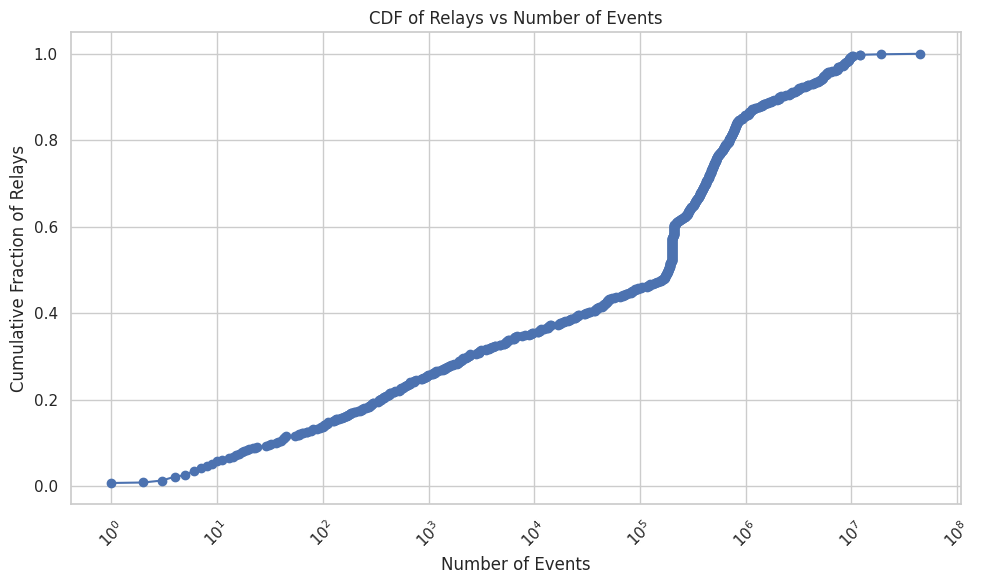

In [12]:
# plot cdf fraction of relays vs number of events
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df['event_count'].value_counts().sort_index().cumsum() / df['event_count'].count(), marker='o')
plt.title('CDF of Relays vs Number of Events')
plt.xlabel('Number of Events')
plt.ylabel('Cumulative Fraction of Relays')
plt.xticks(rotation=45)
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
query = "SELECT COUNT(*) FROM events WHERE kind = 1"
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
print(f"Number of events in the database: {rows[0][0]}")

Number of events in the database: 66423419


In [14]:
query = """
SELECT relay_url, COUNT(*) AS count
FROM relay_metadata
GROUP BY relay_url
ORDER BY count DESC
"""

bigbrotr.execute(query)
rows = bigbrotr.fetchall()

# Create DataFrame
df = pd.DataFrame(rows, columns=['relay_url', 'count'])
df

,relay_url,count
0,wss://orangesync.tech,48
1,wss://filter.nostr.wine,48
2,wss://fl.purplerelay.com,48
3,wss://freelay.sovbit.host,48
4,wss://frens.nostr1.com,48
...,...,...
1233,wss://maqjy352gudc766qivysr6dq6h6vjvxjyuvuv3xt...,1
1234,wss://eupo43gj24.execute-api.us-east-1.amazona...,1
1235,wss://test.mleku.dev,1
1236,wss://2u667tb3jvjynlpkzp5cngutfn4hhzgljjw6xnho...,1


array([[<Axes: title={'center': 'count'}>]], dtype=object)

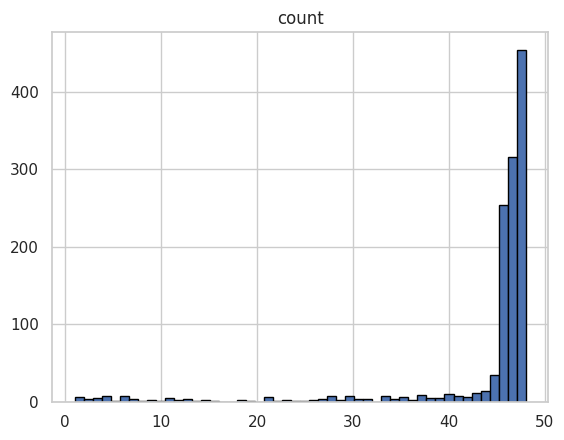

In [15]:
df.hist(column='count', bins=50, edgecolor='black')

In [16]:
query = """
SELECT
    latest.relay_url AS relay_url,
    e.created_at AS timestamp,
    latest.seen_at AS seen_at
FROM (
    SELECT DISTINCT ON (relay_url)
        relay_url,
        seen_at,
        event_id
    FROM
        events_relays
    ORDER BY
        relay_url,
        seen_at DESC
) AS latest
JOIN events e ON e.id = latest.event_id;
"""
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
df = pd.DataFrame(rows, columns=['relay_url', 'timestamp', 'seen_at'])

In [ ]:
df['timestamp_month'] = pd.to_datetime(df['timestamp'], unit='s').dt.to_period('M')
df['seen_at_day'] = pd.to_datetime(df['seen_at'], unit='s').dt.to_period('D')
df = df.sort_values(by=['seen_at_day', 'timestamp_month'], ascending=True)
df.to_csv('relay_synchronization.csv', index=False)

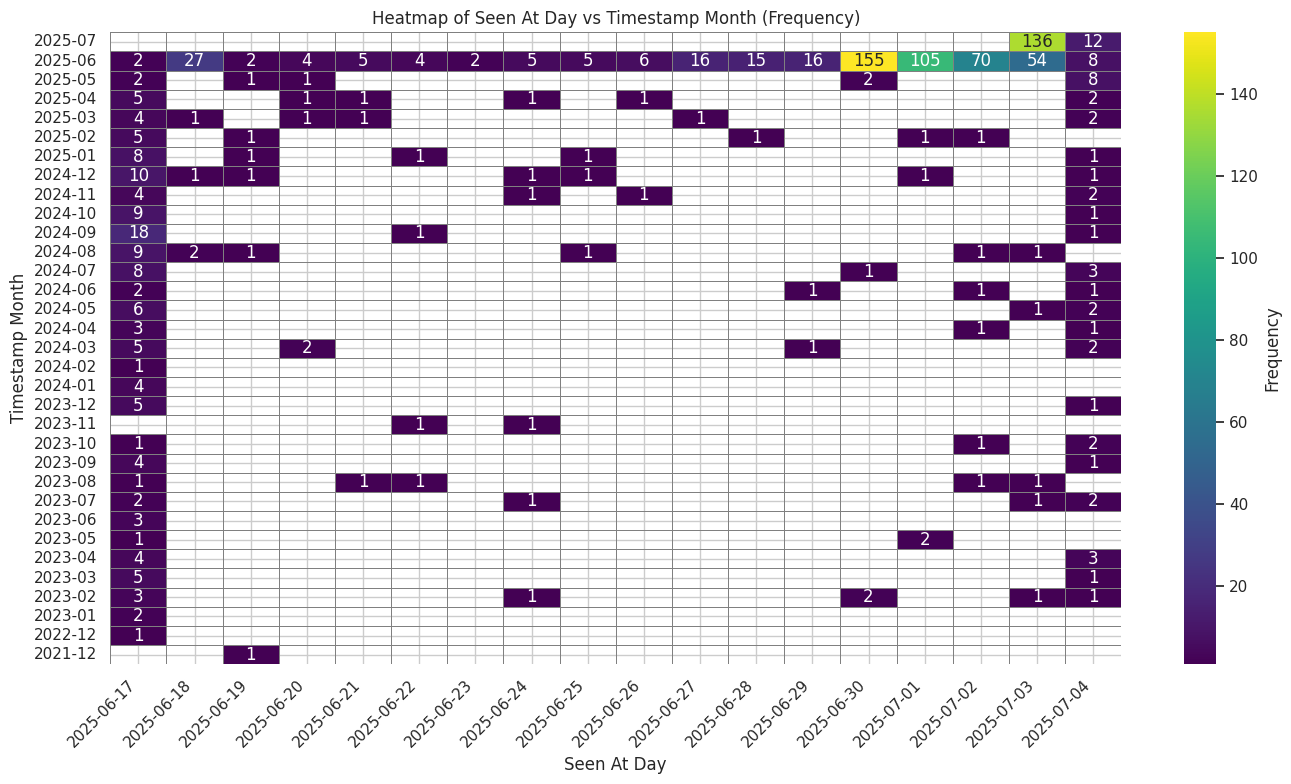

In [42]:
df = pd.read_csv('relay_synchronization.csv')
# Copia temporanea
tmp = df.copy()

tmp['timestamp_month_dt'] = tmp['timestamp_month']
tmp['seen_at_day_dt'] = tmp['seen_at_day']

# Calcola frequenze
tmp = (
    tmp.groupby(['timestamp_month_dt', 'seen_at_day_dt'])
    .size()
    .reset_index(name='frequency')
)

# Pivot
heatmap_data = tmp.pivot(index='timestamp_month_dt', columns='seen_at_day_dt', values='frequency')

# Ordina l’asse Y dal più recente al meno recente
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt='g',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Frequency'},
    ax=ax
)

# Format x-axis (daily)
ax.set_xlabel("Seen At Day")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Format y-axis (monthly)
ax.set_ylabel("Timestamp Month")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Titolo
ax.set_title("Heatmap of Seen At Day vs Timestamp Month (Frequency)")

plt.tight_layout()
plt.savefig('relay_synchronization.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
query = '''
SELECT MIN(inserted_at) AS first_inserted_at
FROM relays
'''
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
first_inserted_at = rows[0][0]
print(f"First inserted relay at: {first_inserted_at}")

First inserted relay at: 1750150988


In [ ]:
# bigbrotr.conn.autocommit = True
# bigbrotr.execute('VACUUM FULL events;')
# bigbrotr.execute('VACUUM FULL events_relays;')
# bigbrotr.execute('VACUUM FULL relay_metadata;')
# bigbrotr.execute('VACUUM FULL relays;')

In [13]:
bigbrotr.close()